# Example of an extraction using tikhonov regularisation

TODO: Explain waht tikhonov regularisation is and why we use it?

## Imports

In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
# TODO astropy has some nice functions for colorbars scaling of astronomical data, might be worth looking into.

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Read some ref files

In [4]:
# Read relevant files TODO maybe we could make a a function that does this in utils?
# ANSWER : Yes, should we do it with the spacetel framework (so not now)?

# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata("/genesis/jwst/userland-soss/loic_review/refs/map_wave_2D_native.fits"))
#wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m1.fits"))
#wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m2.fits"))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata("/genesis/jwst/userland-soss/loic_review/refs/map_profile_2D_native.fits").squeeze())
#spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze())
#spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]   #Find shape tu put it to o1 everywhere

#### Convolution kernels ####
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Load simulation

In [5]:
# Import custom function to read toy simulation
from sys import path  # TODO all import should be at the top. 
# Answer: this is temporary since we should have better simulations eventually
#         and my format was very custom. That's why I let this whole section
#         in a separate bloc.
path.append("Fake_data")
from simu_utils import load_simu  # TODO can this function be moved to utils?
# Answer: same as previous comment: very custom format. Should be changed.
# Load a simulation
#simu = load_simu("Fake_data/phoenix_teff_02300_scale_1.0e+02.fits")
data = simu["data"]   #Put clear000000.fits instead
#data = simu["data"]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [6]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # In counts?

# Wavelength extraction grid oversampling.
params["n_os"] = 5  # TODO explain a bit more how the grid is determined?
# Answer: I was thinking of explaining all inputs in another notebook or text?
#         Since this parameter is needed for every extraction, I didn't want
#         to re-explain it in all examples. What do you think?

# Threshold on the spatial profile. 
# Only pixels above this threshold will be used for extraction.
# (for at least one order)
params["thresh"] = 1e-4  # Same units as the spatial profiles

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [7]:
extract = TrpzOverlap(*ref_files_args, **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

Testing factors...
14/14


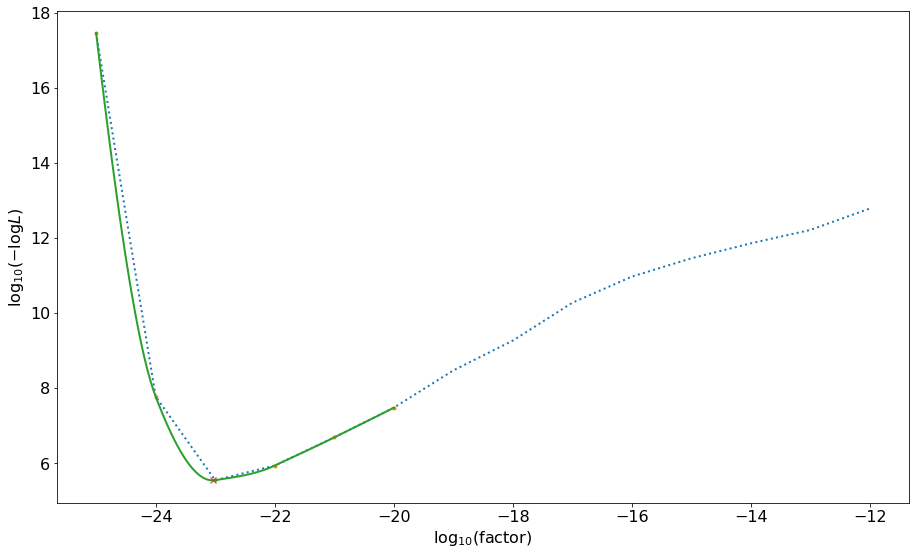

In [8]:
# Determine which factors to tests.
factors = np.logspace(-25, -12, 14)

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors.
tests = extract.get_tikho_tests(factors, data=data, sig=sig)  # TODO sig is the uncertainty on the date here so it might be good to call it that?

# Find the best factor.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


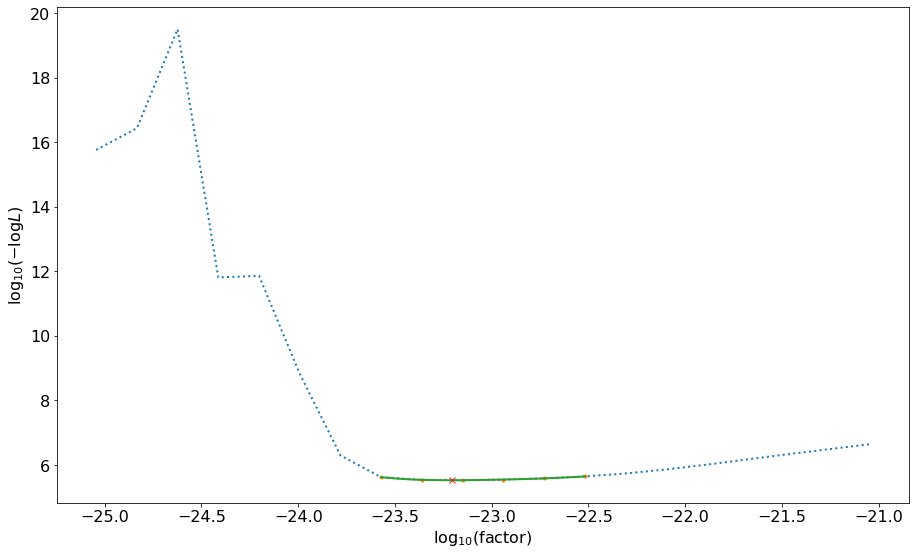

In [9]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# No need to specify `data` and `sig` again. 
# TODO: why not? Wouldn't it be better to require that to avoid confusion?
# Answer: When a reference file or science file is specified, the class keeps it
#         as an attribute. When an extraction is called, it is updated if specified.
#         It is done to save some text when iterating on the spatial profile, for
#         example, and to save time (some matrix multiplications don't need to be 
#         re-computed). But I'm open to discuss it!
tests = extract.get_tikho_tests(factors, data=data, sig=sig)
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Extract the oversampled spectrum $f_k$
TODO explain what f_k is. <br>
I was thinking of explaining f_k in another notebook or text?
I didn't want to re-explain it in all examples. What do you think?

Can be done in a loop for a timeseries and/or iteratively for different estimates of the reference files.

In [10]:
# Extract the spectrum.
f_k = extract.extract(data=data, sig=sig, tikhonov=True, factor=best_fac)  
# Could we make change this method to __call__?
# Very good idea!

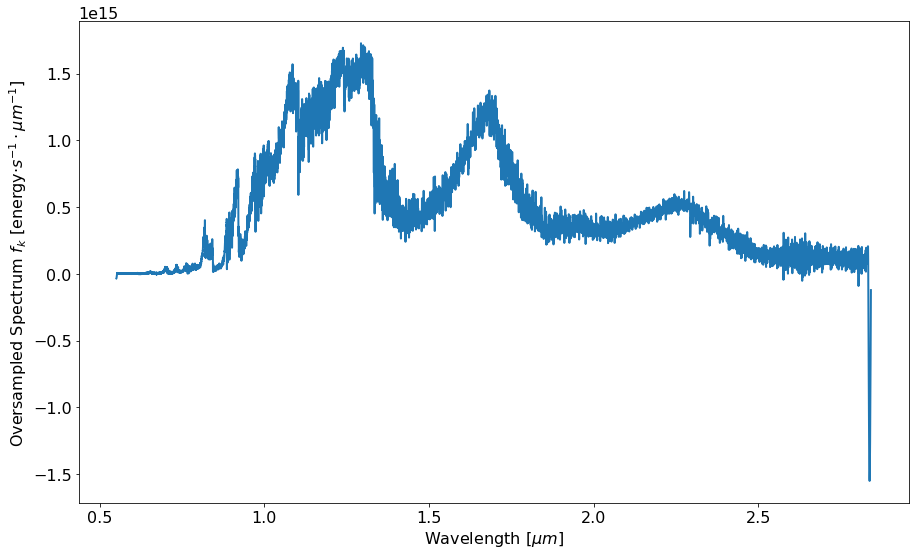

In [11]:
# Plot the extracted spectrum.
plt.plot(extract.lam_grid, f_k)

plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Oversampled Spectrum $f_k$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")
# For now, arbitrairy units, but it should be the flux that hits the detector,
# so energy/time/wavelength

plt.tight_layout()
plt.show()

### Bin to pixel native sampling
To get a result comparable to typical extraction methods, we need to integrate the oversampled spectrum ($f_k$) to a grid representative of the native pixel sampling (for each order). This integration is done according to the equation
\begin{equation}
\mathrm{bin}_{i} = \int_{\lambda_{ni}^-}^{\lambda_{ni}^+} T_n(\lambda)\tilde{f}_n(\lambda)\lambda d\lambda \, ,
\end{equation}
where $n$ is a given order, $T_n$ is the throughput of the order and $\tilde{f}_n$ is the underlying flux convolved to the order $n$ resolution. The result of this integral will be in fake counts (it is not directly the sum of the counts so that's why I call it fake). 

One could directly extract the integrated flux by setting the throughput to $T_n(\lambda) = 1$ (see second example). The result would then be in flux units instead of counts.

#### Bin in counts

In [12]:
# Save the output in a list for different orders.

f_bin_list = []  # Integrated flux.
lam_bin_list = []  # Wavelength grid.

for i_ord in range(extract.n_ord): # TODO I think we can make it so we just get the order m=1,2 and never have to deal with an index as well.
    
    # Integrate.
    lam_bin, f_bin = extract.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    
    # Save.
    f_bin_list.append(f_bin)
    lam_bin_list.append(lam_bin)

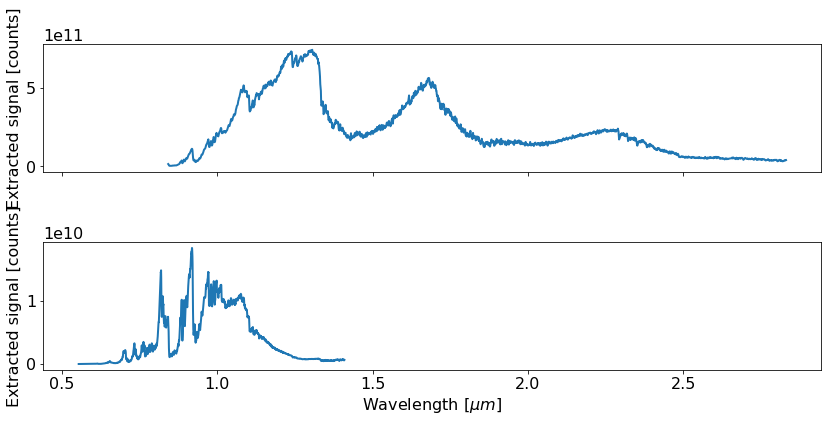

In [13]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

for i_ord in range(extract.n_ord):
    label = extract.orders[i_ord]
    ax[i_ord].plot(lam_bin_list[i_ord], f_bin_list[i_ord], label=label)
    
ax[0].set_ylabel("Extracted signal [counts]")
    
ax[1].set_xlabel("Wavelength [$\mu m$]")
ax[1].set_ylabel("Extracted signal [counts]")

plt.tight_layout()
plt.show()

#### Bin in flux units

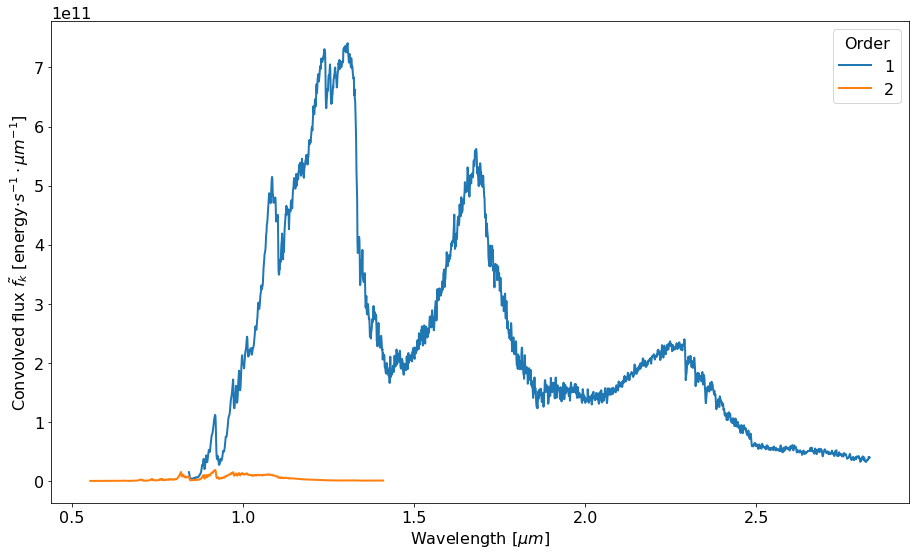

In [14]:
# Set throughput to 1
def throughput(x):
    return np.ones_like(x)

for i_ord in range(extract.n_ord): # TODO I think we can make it so we just get the order m=1,2 and never have to deal with an index as well.
    
    # Integrate.
    lam_bin, f_bin = extract.bin_to_pixel(f_k=f_k, i_ord=i_ord, throughput=throughput)
    
    # Plot
    label = extract.orders[i_ord]
    plt.plot(lam_bin_list[i_ord], f_bin_list[i_ord], label=label)

plt.ylabel(r"Convolved flux $\tilde{f_k}$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")  
plt.xlabel("Wavelength [$\mu m$]")

plt.tight_layout()
plt.legend(title="Order")
plt.show()

## Quality estimate

### Rebuild the detector

In [15]:
rebuilt = extract.rebuild(f_k)

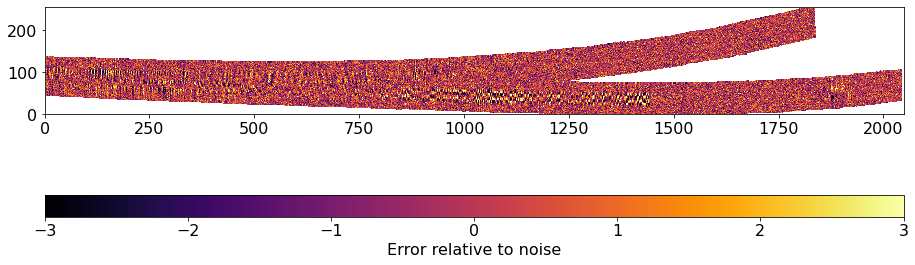

In [17]:
plt.subplot(111, aspect='equal')

plt.pcolormesh((rebuilt - data)/sig, vmin=-3, vmax=3)

plt.colorbar(label="Error relative to noise", orientation='horizontal', aspect=40)

plt.tight_layout()
plt.show()

We can see that we are very close to the photon noise limit in this case. There are some small structures in the 2nd order in the overlap region, but the extracted spectrum is dominated by the 1st order in this wavelength region anyway, due to the higher throughput.